# What is ensemble learning ?
In statistics and machine learning, ensemble methods use multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms alone.

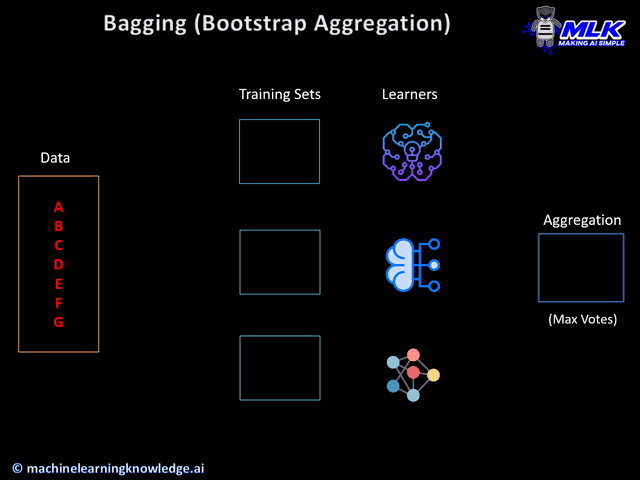

In [ ]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')

# Note 
You may or may not have to install some extra libraries , such as - cudf,timm,tqdm,cuml,cupy,etc.

In [ ]:
import numpy as np 
import pandas as pd 

import math
import random 
import os 
import cv2
import timm

from tqdm import tqdm 

import albumentations as A 
from albumentations.pytorch.transforms import ToTensorV2

import torch 
from torch.utils.data import Dataset 
from torch import nn
import torch.nn.functional as F 

import gc
import cudf
import cuml
import cupy
from cuml.feature_extraction.text import TfidfVectorizer
from cuml.neighbors import NearestNeighbors

In [ ]:
class CFG:
    
    img_size = 512
    fc_dim = 512
    batch_size = 12
    seed = 2020
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    classes = 11014
    
    model_name = 'tf_efficientnet_b5_ns'
    model_name1 =  'tf_efficientnet_b4'
    model_name2 = 'eca_nfnet_l0'
    
    model_path = '../input/shopee-pytorch-models/arcface_512x512_eff_b5_.pt'
    model_path1 = '../input/utils-shopee/arcface_512x512_tf_efficientnet_b4_LR.pt'
    model_path2 = '../input/shopee-pytorch-models/arcface_512x512_nfnet_l0 (mish).pt'
    
    scale = 30 
    margin = 0.05

In [ ]:
def read_dataset():
    df = pd.read_csv('../input/shopee-product-matching/test.csv')
    df_cu = cudf.DataFrame(df)
    image_paths = '../input/shopee-product-matching/test_images/' + df['image']
    return df, df_cu, image_paths

In [ ]:
def seed_torch(seed=456):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_torch(CFG.seed)

In [ ]:
def combine_predictions(row):
    x = np.concatenate([row['image_predictions'], row['text_predictions']])
    return ' '.join( np.unique(x))

In [ ]:
def get_image_predictions(df, embeddings1, embeddings2, embeddings3, threshold = 3.4):
    
    if len(df) > 3:
        KNN = 50
    else : 
        KNN = 3
    

    model = NearestNeighbors(n_neighbors = KNN)
    model.fit(embeddings1)
    distances, indices = model.kneighbors(embeddings1)
    
    threshold = 1.6
    predictions1 = []
    for k in tqdm(range(embeddings1.shape[0])):
        idx = np.where(distances[k,] < threshold)[0]
        ids = indices[k,idx]
        posting_ids = list(df['posting_id'].iloc[ids])
        predictions1.append(posting_ids)
        
    del model, distances, indices, embeddings1
    gc.collect()

    model = NearestNeighbors(n_neighbors = KNN)
    model.fit(embeddings2)
    distances, indices = model.kneighbors(embeddings2)
    
    threshold = 4.4999
    predictions2 = []
    for k in tqdm(range(embeddings2.shape[0])):
        idx = np.where(distances[k,] < threshold)[0]
        ids = indices[k,idx]
        posting_ids = list(df['posting_id'].iloc[ids])
        predictions2.append(posting_ids)
        
    del model, distances, indices, embeddings2
    gc.collect()
    
    model = NearestNeighbors(n_neighbors = KNN, metric = 'cosine')
    model.fit(embeddings3)
    distances, indices = model.kneighbors(embeddings3)
    
    threshold=0.36
    predictions3 = []
    for k in tqdm(range(embeddings3.shape[0])):
        idx = np.where(distances[k,] < threshold)[0]
        ids = indices[k,idx]
        posting_ids = list(df['posting_id'].iloc[ids])
        predictions3.append(posting_ids)
        
    del model, distances, indices, embeddings3
    gc.collect()

    predictions = [list(set(a + c)) for a, b, c in zip(predictions1, predictions2, predictions3)]
    
    return predictions

In [ ]:
def get_test_transforms():

    return A.Compose(
        [
            A.Resize(CFG.img_size,CFG.img_size,always_apply=True),
            A.Normalize(),
        ToTensorV2(p=1.0)
        ]
    )

In [ ]:
class ShopeeDataset(Dataset):
    def __init__(self, image_paths, transforms=None):

        self.image_paths = image_paths
        self.augmentations = transforms

    def __len__(self):
        return self.image_paths.shape[0]

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.augmentations:
            augmented = self.augmentations(image=image)
            image = augmented['image']       
    
        return image,torch.tensor(1)

In [ ]:
class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features, scale=30.0, margin=0.50, easy_margin=False, ls_eps=0.0):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.scale = scale
        self.margin = margin
        self.ls_eps = ls_eps
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(margin)
        self.sin_m = math.sin(margin)
        self.th = math.cos(math.pi - margin)
        self.mm = math.sin(math.pi - margin) * margin

    def forward(self, input, label):
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = torch.zeros(cosine.size(), device='cuda')
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.scale

        return output

class ShopeeModel(nn.Module):

    def __init__(
        self,
        n_classes = CFG.classes,
        model_name = CFG.model_name,
        fc_dim = 512,
        margin = CFG.margin,
        scale = CFG.scale,
        use_fc = False,
        pretrained = False):


        super(ShopeeModel,self).__init__()
        print('Building Model Backbone for {} model'.format(model_name))

        self.backbone = timm.create_model(model_name, pretrained=pretrained)

        if model_name == 'resnext50_32x4d':
            final_in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
            self.backbone.global_pool = nn.Identity()

        elif model_name == 'efficientnet_b3':
            final_in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()
            self.backbone.global_pool = nn.Identity()

        elif model_name == 'tf_efficientnet_b5_ns':
            final_in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()
            self.backbone.global_pool = nn.Identity()
        
        elif model_name == 'nfnet_f3':
            final_in_features = self.backbone.head.fc.in_features
            self.backbone.head.fc = nn.Identity()
            self.backbone.head.global_pool = nn.Identity()

        self.pooling =  nn.AdaptiveAvgPool2d(1)

        self.use_fc = use_fc

        self.dropout = nn.Dropout(p=0.0)
        self.fc = nn.Linear(final_in_features, fc_dim)
        self.bn = nn.BatchNorm1d(fc_dim)
        self._init_params()
        final_in_features = fc_dim

        self.final = ArcMarginProduct(
            final_in_features,
            n_classes,
            scale = scale,
            margin = margin,
            easy_margin = False,
            ls_eps = 0.0
        )

    def _init_params(self):
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0)
        nn.init.constant_(self.bn.weight, 1)
        nn.init.constant_(self.bn.bias, 0)

    def forward(self, image, label):
        feature = self.extract_feat(image)
        return feature

    def extract_feat(self, x):
        batch_size = x.shape[0]
        x = self.backbone(x)
        x = self.pooling(x).view(batch_size, -1)

        if self.use_fc:
            x = self.dropout(x)
            x = self.fc(x)
            x = self.bn(x)
        return x
    
    
class ShopeeModel1(nn.Module):
    def __init__(
        self,
        n_classes = CFG.classes,
        model_name = CFG.model_name1,
        fc_dim = CFG.fc_dim,
        margin = CFG.margin,
        scale = CFG.scale,
        use_fc = True,
        pretrained = True):

        super(ShopeeModel1, self).__init__()
    
        self.backbone = timm.create_model(model_name, pretrained=pretrained)
        in_features = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Identity()
        self.backbone.global_pool = nn.Identity()
        self.pooling =  nn.AdaptiveAvgPool2d(1)
        self.use_fc = use_fc

        if use_fc:
            self.dropout = nn.Dropout(p=0.1)
            self.classifier = nn.Linear(in_features, fc_dim)
            self.bn = nn.BatchNorm1d(fc_dim)
            self._init_params()
            in_features = fc_dim

        self.final = ArcMarginProduct(
            in_features,
            n_classes,
            scale = scale,
            margin = margin,
            easy_margin = False,
            ls_eps = 0.0
        )

    def _init_params(self):
        nn.init.xavier_normal_(self.classifier.weight)
        nn.init.constant_(self.classifier.bias, 0)
        nn.init.constant_(self.bn.weight, 1)
        nn.init.constant_(self.bn.bias, 0)

    def forward(self, image, label):
        features = self.extract_features(image)
        if self.training:
            logits = self.final(features, label)
            return logits
        else:
            return features

    def extract_features(self, x):
        batch_size = x.shape[0]
        x = self.backbone(x)
        x = self.pooling(x).view(batch_size, -1)

        if self.use_fc and self.training:
            x = self.dropout(x)
            x = self.classifier(x)
            x = self.bn(x)
        return x
    
class ShopeeModel2(nn.Module):

    def __init__(
        self,
        n_classes = CFG.classes,
        model_name = CFG.model_name2,
        fc_dim = 512,
        margin = CFG.margin,
        scale = CFG.scale,
        use_fc = True,
        pretrained = False):


        super(ShopeeModel2,self).__init__()

        self.backbone = timm.create_model(model_name, pretrained=pretrained)

        if model_name == 'resnext50_32x4d':
            final_in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
            self.backbone.global_pool = nn.Identity()

        elif model_name == 'efficientnet_b3':
            final_in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()
            self.backbone.global_pool = nn.Identity()

        elif model_name == 'tf_efficientnet_b5_ns':
            final_in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()
            self.backbone.global_pool = nn.Identity()
        
        elif model_name == 'eca_nfnet_l0':
            final_in_features = self.backbone.head.fc.in_features
            self.backbone.head.fc = nn.Identity()
            self.backbone.head.global_pool = nn.Identity()

        self.pooling =  nn.AdaptiveAvgPool2d(1)

        self.use_fc = use_fc

        self.dropout = nn.Dropout(p=0.0)
        self.fc = nn.Linear(final_in_features, fc_dim)
        self.bn = nn.BatchNorm1d(fc_dim)
        self._init_params()
        final_in_features = fc_dim

        self.final = ArcMarginProduct(
            final_in_features,
            n_classes,
            scale = scale,
            margin = margin,
            easy_margin = False,
            ls_eps = 0.0
        )

    def _init_params(self):
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0)
        nn.init.constant_(self.bn.weight, 1)
        nn.init.constant_(self.bn.bias, 0)

    def forward(self, image, label):
        feature = self.extract_feat(image)
        return feature

    def extract_feat(self, x):
        batch_size = x.shape[0]
        x = self.backbone(x)
        x = self.pooling(x).view(batch_size, -1)

        if self.use_fc:
            x = self.dropout(x)
            x = self.fc(x)
            x = self.bn(x)
        return x

In [ ]:
class Mish_func(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, i):
        result = i * torch.tanh(F.softplus(i))
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
  
        v = 1. + i.exp()
        h = v.log() 
        grad_gh = 1./h.cosh().pow_(2) 
        
        grad_hx = i.sigmoid()

        grad_gx = grad_gh *  grad_hx
        
        grad_f =  torch.tanh(F.softplus(i)) + i * grad_gx 
        
        return grad_output * grad_f 


class Mish(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        pass
    def forward(self, input_tensor):
        return Mish_func.apply(input_tensor)


def replace_activations(model, existing_layer, new_layer):
    
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            model._modules[name] = replace_activations(module, existing_layer, new_layer)

        if type(module) == existing_layer:
            layer_old = module
            layer_new = new_layer
            model._modules[name] = layer_new
    return model

In [ ]:
def get_image_embeddings(image_paths, model_name = CFG.model_name):
    embeds = []
    
    model = ShopeeModel(model_name = model_name)
    model.eval()
    model.load_state_dict(torch.load(CFG.model_path))
    model = model.to(CFG.device)

    image_dataset = ShopeeDataset(image_paths=image_paths,transforms=get_test_transforms())
    image_loader = torch.utils.data.DataLoader(
        image_dataset,
        batch_size=CFG.batch_size,
        pin_memory=True,
        drop_last=False,
        num_workers=4
    )
    
    with torch.no_grad():
        for img,label in tqdm(image_loader): 
            img = img.cuda()
            label = label.cuda()
            feat = model(img,label)
            image_embeddings = feat.detach().cpu().numpy()
            embeds.append(image_embeddings)
    
    
    del model, image_embeddings
    image_embeddings1 = np.concatenate(embeds)
    del embeds
    gc.collect()
    
    model = ShopeeModel1(pretrained=False).to(CFG.device)
    model.load_state_dict(torch.load(CFG.model_path1))
    model.eval()

    image_dataset = ShopeeDataset(image_paths=image_paths, transforms=get_test_transforms())
    image_loader = torch.utils.data.DataLoader(
        image_dataset,
        batch_size=CFG.batch_size,
        num_workers=4
    )

    embeds1 = []
    with torch.no_grad():
        for img,label in tqdm(image_loader): 
            img = img.cuda()
            label = label.cuda()
            features = model(img,label)
            image_embeddings = features.detach().cpu().numpy()
            embeds1.append(image_embeddings)

    del model, image_embeddings
    image_embeddings2 = np.concatenate(embeds1)
    del embeds1
    gc.collect()
    
    model = ShopeeModel2()
    model.eval()
    model = replace_activations(model, torch.nn.SiLU, Mish())

    model.load_state_dict(torch.load(CFG.model_path2))
    model = model.to(CFG.device)
    
    image_dataset = ShopeeDataset(image_paths=image_paths,transforms=get_test_transforms())
    image_loader = torch.utils.data.DataLoader(
        image_dataset,
        batch_size=CFG.batch_size,
        pin_memory=True,
        drop_last=False,
        num_workers=4
    )
    
    embeds2 = []
    with torch.no_grad():
        for img,label in tqdm(image_loader): 
            img = img.cuda()
            label = label.cuda()
            feat = model(img,label)
            image_embeddings = feat.detach().cpu().numpy()
            embeds2.append(image_embeddings)
    
    del model
    image_embeddings3 = np.concatenate(embeds2)
    del embeds2
    gc.collect()
    
    return image_embeddings1, image_embeddings2, image_embeddings3

In [ ]:
def get_text_predictions(df, max_features = 25_000):
    
    model = TfidfVectorizer(stop_words = 'english', binary = True, max_features = max_features)
    text_embeddings = model.fit_transform(df_cu['title']).toarray()
    preds = []
    CHUNK = 1024*4

    CTS = len(df)//CHUNK
    if len(df)%CHUNK!=0: CTS += 1
    for j in range( CTS ):

        a = j*CHUNK
        b = (j+1)*CHUNK
        b = min(b,len(df))

        cts = cupy.matmul( text_embeddings, text_embeddings[a:b].T).T

        for k in range(b-a):
            IDX = cupy.where(cts[k,]>0.75)[0]
            o = df.iloc[cupy.asnumpy(IDX)].posting_id.values
            preds.append(o)
    
    del model,text_embeddings
    gc.collect()
    return preds

In [ ]:
df,df_cu,image_paths = read_dataset()

In [ ]:
image_embeddings1, image_embeddings2, image_embeddings3 = get_image_embeddings(image_paths.values)
image_predictions = get_image_predictions(df, image_embeddings1, image_embeddings2, image_embeddings3, threshold = 1.6)
text_predictions = get_text_predictions(df, max_features = 25_000)

In [ ]:
df['image_predictions'] = image_predictions
df['text_predictions'] = text_predictions
df['matches'] = df.apply(combine_predictions, axis = 1)
df[['posting_id', 'matches']].to_csv('submission.csv', index = False)